In [5]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler

# Data

In [7]:
df = pd.read_csv('data/minist_train.csv')

df_sample = df.sample(10000)

y = df_sample[df_sample.columns[0]]
X = df_sample[df_sample.columns[1:]]

# split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality Reduction

## ICA

In [8]:
X_ICA = FastICA(n_components = 5).fit_transform(X)

# ICA with Clustering

In [9]:
k = 7
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(X_ICA)

array([[0.02629959, 0.00966525, 0.03143031, ..., 0.02037389, 0.02506155,
        0.03002721],
       [0.0283368 , 0.01243075, 0.03990959, ..., 0.03200268, 0.03352876,
        0.03174181],
       [0.02262036, 0.02251549, 0.01901731, ..., 0.01616264, 0.01593699,
        0.01935614],
       ...,
       [0.03144008, 0.02536703, 0.02021554, ..., 0.02668849, 0.00535261,
        0.02231722],
       [0.01427249, 0.02759678, 0.01068504, ..., 0.02193876, 0.02346291,
        0.02894198],
       [0.0309948 , 0.02577784, 0.01961527, ..., 0.01617841, 0.01370999,
        0.02700764]])

In [10]:
X_KMeans = np.append(X_ICA, k_means_clustering.fit_transform(X_ICA), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(X_KMeans, y, test_size=0.3, random_state=42)

In [11]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_KMeans_train, y_KMeans_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 0.001, 'hidden_layer_sizes': 20}
Time to train: 40693.01016783714
Accuracy for best neural network: 0.67
Time to infer: 0.00400996208190918


In [12]:
confusion_matrix(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))

array([[235,   0,   1,   0,   1,  31,   7,   2,  13,   0],
       [  0, 305,   8,   4,   0,   1,   1,   3,   8,   0],
       [ 14,   8, 159,  12,  16,   4,  88,   1,  12,   1],
       [  4,   3,   8, 217,   1,  22,   4,   0,  29,   6],
       [  0,   4,   0,   0, 189,   0,  10,  15,   6,  59],
       [  7,  10,  15,  63,   5, 132,   9,  16,  15,   7],
       [  2,   6,  72,   0,  16,   1, 181,   0,   8,   0],
       [  3,  14,   0,   1,  15,   5,   3, 251,   7,  23],
       [  6,   4,  13,  25,   4,  12,   4,   1, 205,  13],
       [  1,   3,   0,   5, 112,   3,   5,  43,   6, 136]])

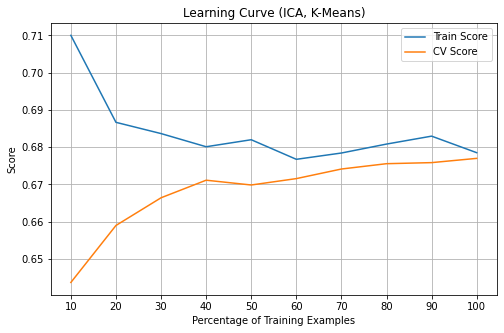

In [13]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_KMeans_train, y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (ICA, K-Means)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_ICA_learning_curve_kmeans.png')
plt.show()

## EM (GMM)

In [14]:
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(X_ICA)
gmm.predict_proba(X_ICA)

array([[6.01212398e-09, 4.53010790e-22, 9.86327043e-01, ...,
        5.31463195e-04, 1.31144442e-02, 2.70432301e-05],
       [4.56152260e-22, 5.95849626e-55, 9.99707837e-01, ...,
        7.17918791e-06, 2.66368206e-04, 1.86159781e-05],
       [6.62056136e-02, 3.67327963e-05, 9.25018402e-02, ...,
        1.42119563e-01, 6.89568702e-02, 1.34004226e-04],
       ...,
       [9.86655386e-01, 9.53037084e-16, 1.60865730e-03, ...,
        1.79064691e-03, 2.01289191e-04, 6.56283630e-06],
       [5.84925074e-05, 3.97143100e-15, 4.80642623e-04, ...,
        7.60947059e-04, 2.35263168e-01, 2.84687991e-05],
       [4.15018834e-01, 2.04377304e-03, 3.84057156e-02, ...,
        1.21319885e-02, 1.36149455e-02, 2.74554992e-05]])

In [15]:
X_GMM = np.append(X_ICA, gmm.predict_proba(X_ICA), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=42)

In [16]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_GMM_train, y_GMM_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 0.001, 'hidden_layer_sizes': 18}
Time to train: 11872.539983034134
Accuracy for best neural network: 0.7133333333333334
Time to infer: 0.004700899124145508


In [17]:
confusion_matrix(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))

array([[252,   0,   3,   0,   3,  16,   8,   0,   8,   0],
       [  0, 299,   2,   8,   2,   0,   7,   3,   7,   2],
       [ 10,   2, 169,  11,  11,   3,  94,   0,  13,   2],
       [  4,   3,   5, 211,   1,  26,   4,   0,  34,   6],
       [  0,   1,   0,   1, 199,   1,  11,  17,   2,  51],
       [  9,   2,   8,  42,   4, 178,   9,  11,  13,   3],
       [  2,   4,  48,   0,  13,   2, 211,   0,   6,   0],
       [  1,   9,   2,   1,  20,   6,   2, 259,   3,  19],
       [  3,   2,   2,  26,   3,  21,   9,   2, 212,   7],
       [  1,   2,   0,   5, 104,   1,   2,  41,   8, 150]])

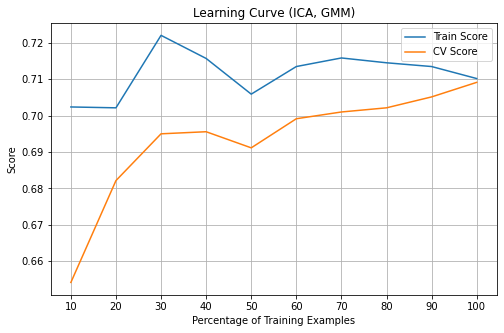

In [18]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_GMM_train, y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (ICA, GMM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_ICA_learning_curve_gmm.png')
plt.show()